## Preamble

In [1]:
import numpy as np
from scipy.optimize import leastsq
import cmath

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle, Wedge

import sys
import os
parent_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
from field_map_g4bl import readFieldMapData
from compute_multipole_components import fitMultipoles, computeField

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../..'))
sys.path.append(parent_dir)
from functions.set_plot_settings import setPlotSettings
setPlotSettings(font=True)

In [2]:
# Path to field map files:
file = 'fieldmap.txt'
file_norot = 'fieldmap_norotations.txt'

# Animation directory:
ani_dir = 'animations/'

In [3]:
# Lattice parameters:
dist = 700 # spacing between solenoid centers (mm)
length = 300 # solenoid length (mm)
a = 420 # solenoid inner radius (mm)
b = 600 # solenoid outer radius (mm)

In [4]:
# Function to plot lattice -- notably without visible rotations:
def plotLattice(ax, label=False):
    for i in range(6):
        ax.axvspan(xmin=-length/2+dist*i, xmax=length/2+dist*i, color='lightgray', alpha=0.5)
        if label:
            if np.mod(i,2) == 0:
                ax.text(dist*i-30, 0.95, s='$+$')
            else:
                ax.text(dist*i-30, 0.95, s='$-$')

In [5]:
# Function to plot solenoid cross-sections -- notably without visible rotations:
def plotSolenoid(ax, color='white'):
    circle_inner = plt.Circle([0,0], radius=a, fill=False, linestyle='-', color=color)
    ax.add_patch(circle_inner)
    circle_outer = plt.Circle([0,0], radius=b, fill=False, linestyle='-', color=color)
    ax.add_patch(circle_outer)
    fill = Wedge(center=(0, 0), r=b, theta1=0, theta2=360, width=b - a, color=color, label='Solenoid', alpha=0.8)
    ax.add_patch(fill)
    ax.legend(loc='upper right')

## Compute multipole components from G4bl fieldmap

In [6]:
data = readFieldMapData(file)

x = np.unique(data['x'].values)
y = np.unique(data['y'].values)
X, Y = np.meshgrid(x, y)

In [7]:
def func(data, X, Y, R_ref=a):

    z_vals = np.arange(0, 4200, 10) # only one HFOFO period
    columns = ['z', 'n=1', 'n=2', 'n=3', 'n=4', 'n=5', 'n=6']
    rows = []
    rows2 = []

    for z in z_vals:

        data_slice = data[data['z'] == z]
        if data_slice.empty:
            continue

        Bx = data_slice.pivot_table(index='y', columns='x', values='Bx').values
        By = data_slice.pivot_table(index='y', columns='x', values='By').values

        max_order = len(columns)-1
        coeffs = fitMultipoles(X, Y, Bx, By, max_order=max_order, R=R_ref)
        coeffs_mag = [abs(coeffs[i]) for i in range(1, max_order+1)] # magnitude
        coeffs_phase = [cmath.phase(coeffs[i]) for i in range(1, max_order+1)] # phase
        rows.append([z] + coeffs_mag)
        rows2.append([z] + coeffs_phase)

    df = pd.DataFrame(rows, columns=columns)
    df2 = pd.DataFrame(rows2, columns=columns)

    return df, df2

In [8]:
df, df2 = func(data, X, Y)

## Plot coefficients vs. z

#### Magnitudes:

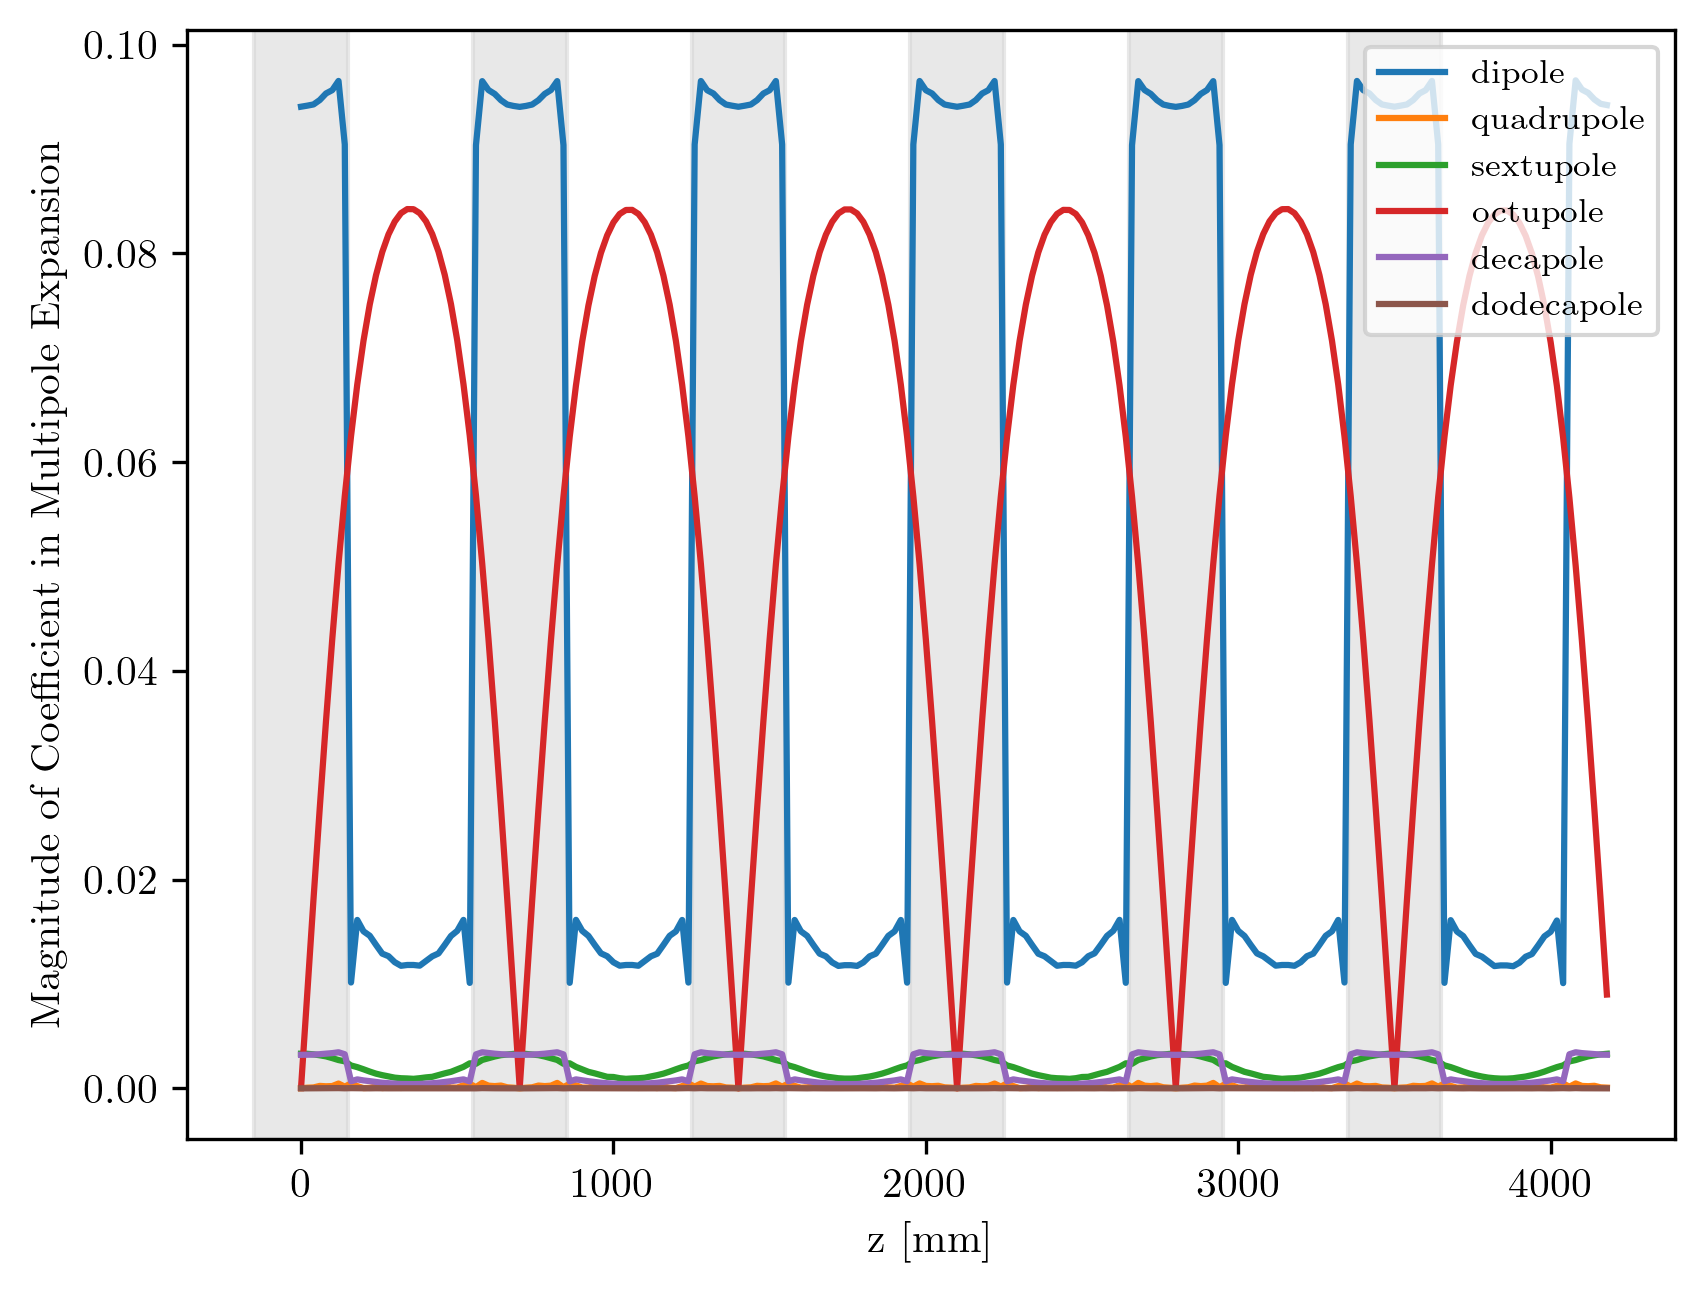

In [9]:
fig, ax = plt.subplots()
plt.plot(df['z'], df['n=1'], label='dipole')
plt.plot(df['z'], df['n=2'], label='quadrupole')
plt.plot(df['z'], df['n=3'], label='sextupole')
plt.plot(df['z'], df['n=4'], label='octupole')
plt.plot(df['z'], df['n=5'], label='decapole')
plt.plot(df['z'], df['n=6'], label='dodecapole')
plt.legend(fontsize=8, loc='upper right')
plt.xlabel('z [mm]')
plt.ylabel('Magnitude of Coefficient in Multipole Expansion')
plotLattice(ax)
plt.show()

#### Phases:

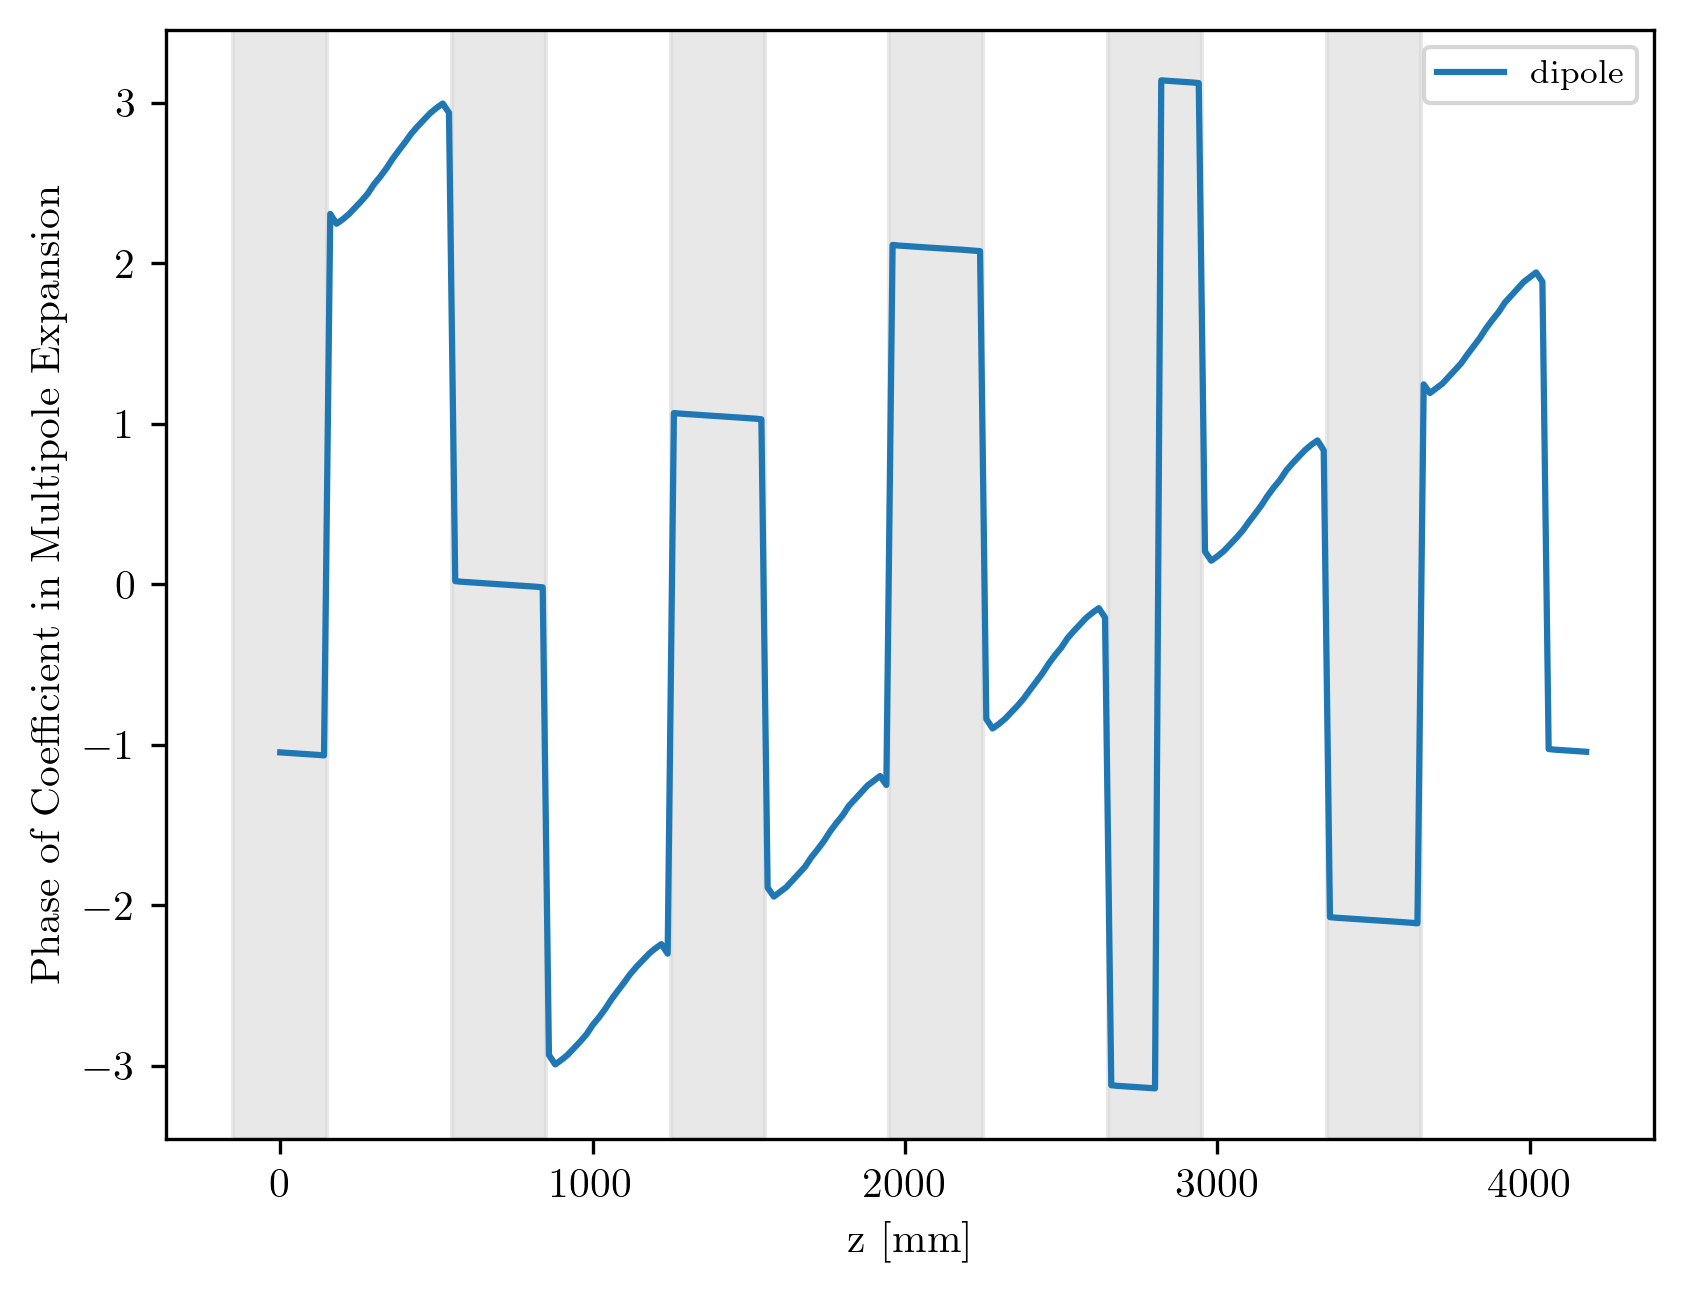

In [10]:
fig, ax = plt.subplots()
plt.plot(df2['z'], df2['n=1'], label='dipole', color='tab:blue')
plt.legend(fontsize=8, loc='upper right')
plt.xlabel('z [mm]')
plt.ylabel('Phase of Coefficient in Multipole Expansion')
plotLattice(ax)
plt.show()

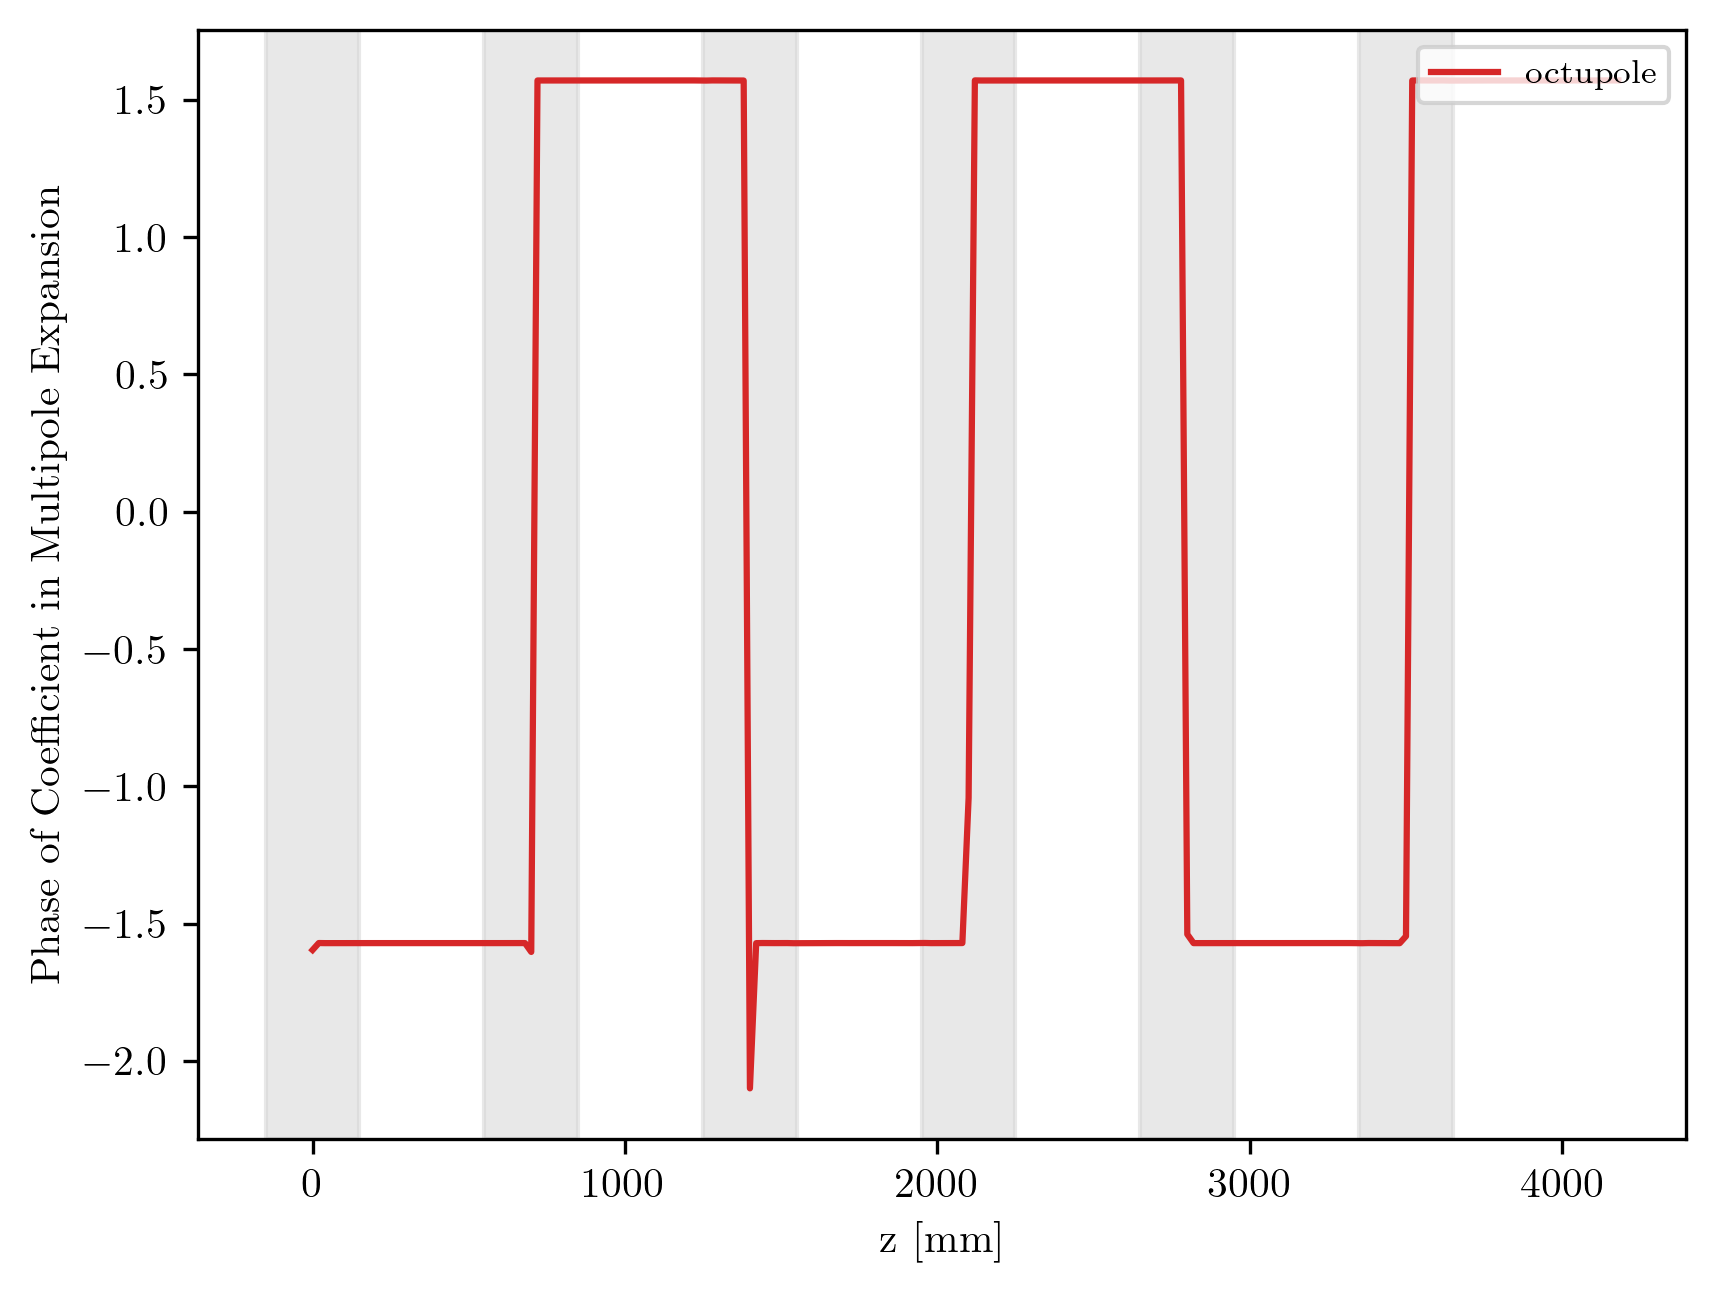

In [11]:
fig, ax = plt.subplots()
plt.plot(df2['z'], df2['n=4'], label='octupole', color='tab:red')
plt.legend(fontsize=8, loc='upper right')
plt.xlabel('z [mm]')
plt.ylabel('Phase of Coefficient in Multipole Expansion')
plotLattice(ax)
plt.show()

## Verify by computing field from multipole coefficients

In [12]:
Bx_by_z = []
By_by_z = []
B_by_z = []
for z in df['z'].values:

        coeff_list_mag = df.loc[np.where(df['z']==z)[0]].values[0][1:]
        coeff_list_phase = df2.loc[np.where(df2['z']==z)[0]].values[0][1:]

        Bx_slice, By_slice = computeField(x, y, coeff_list_mag, coeff_list_phase)
        Bx_by_z.append(Bx_slice)
        By_by_z.append(By_slice)
        theta = np.arctan2(By_slice, Bx_slice)
        B = Bx_slice*np.cos(theta) + By_slice*np.sin(theta)
        B_by_z.append(B)

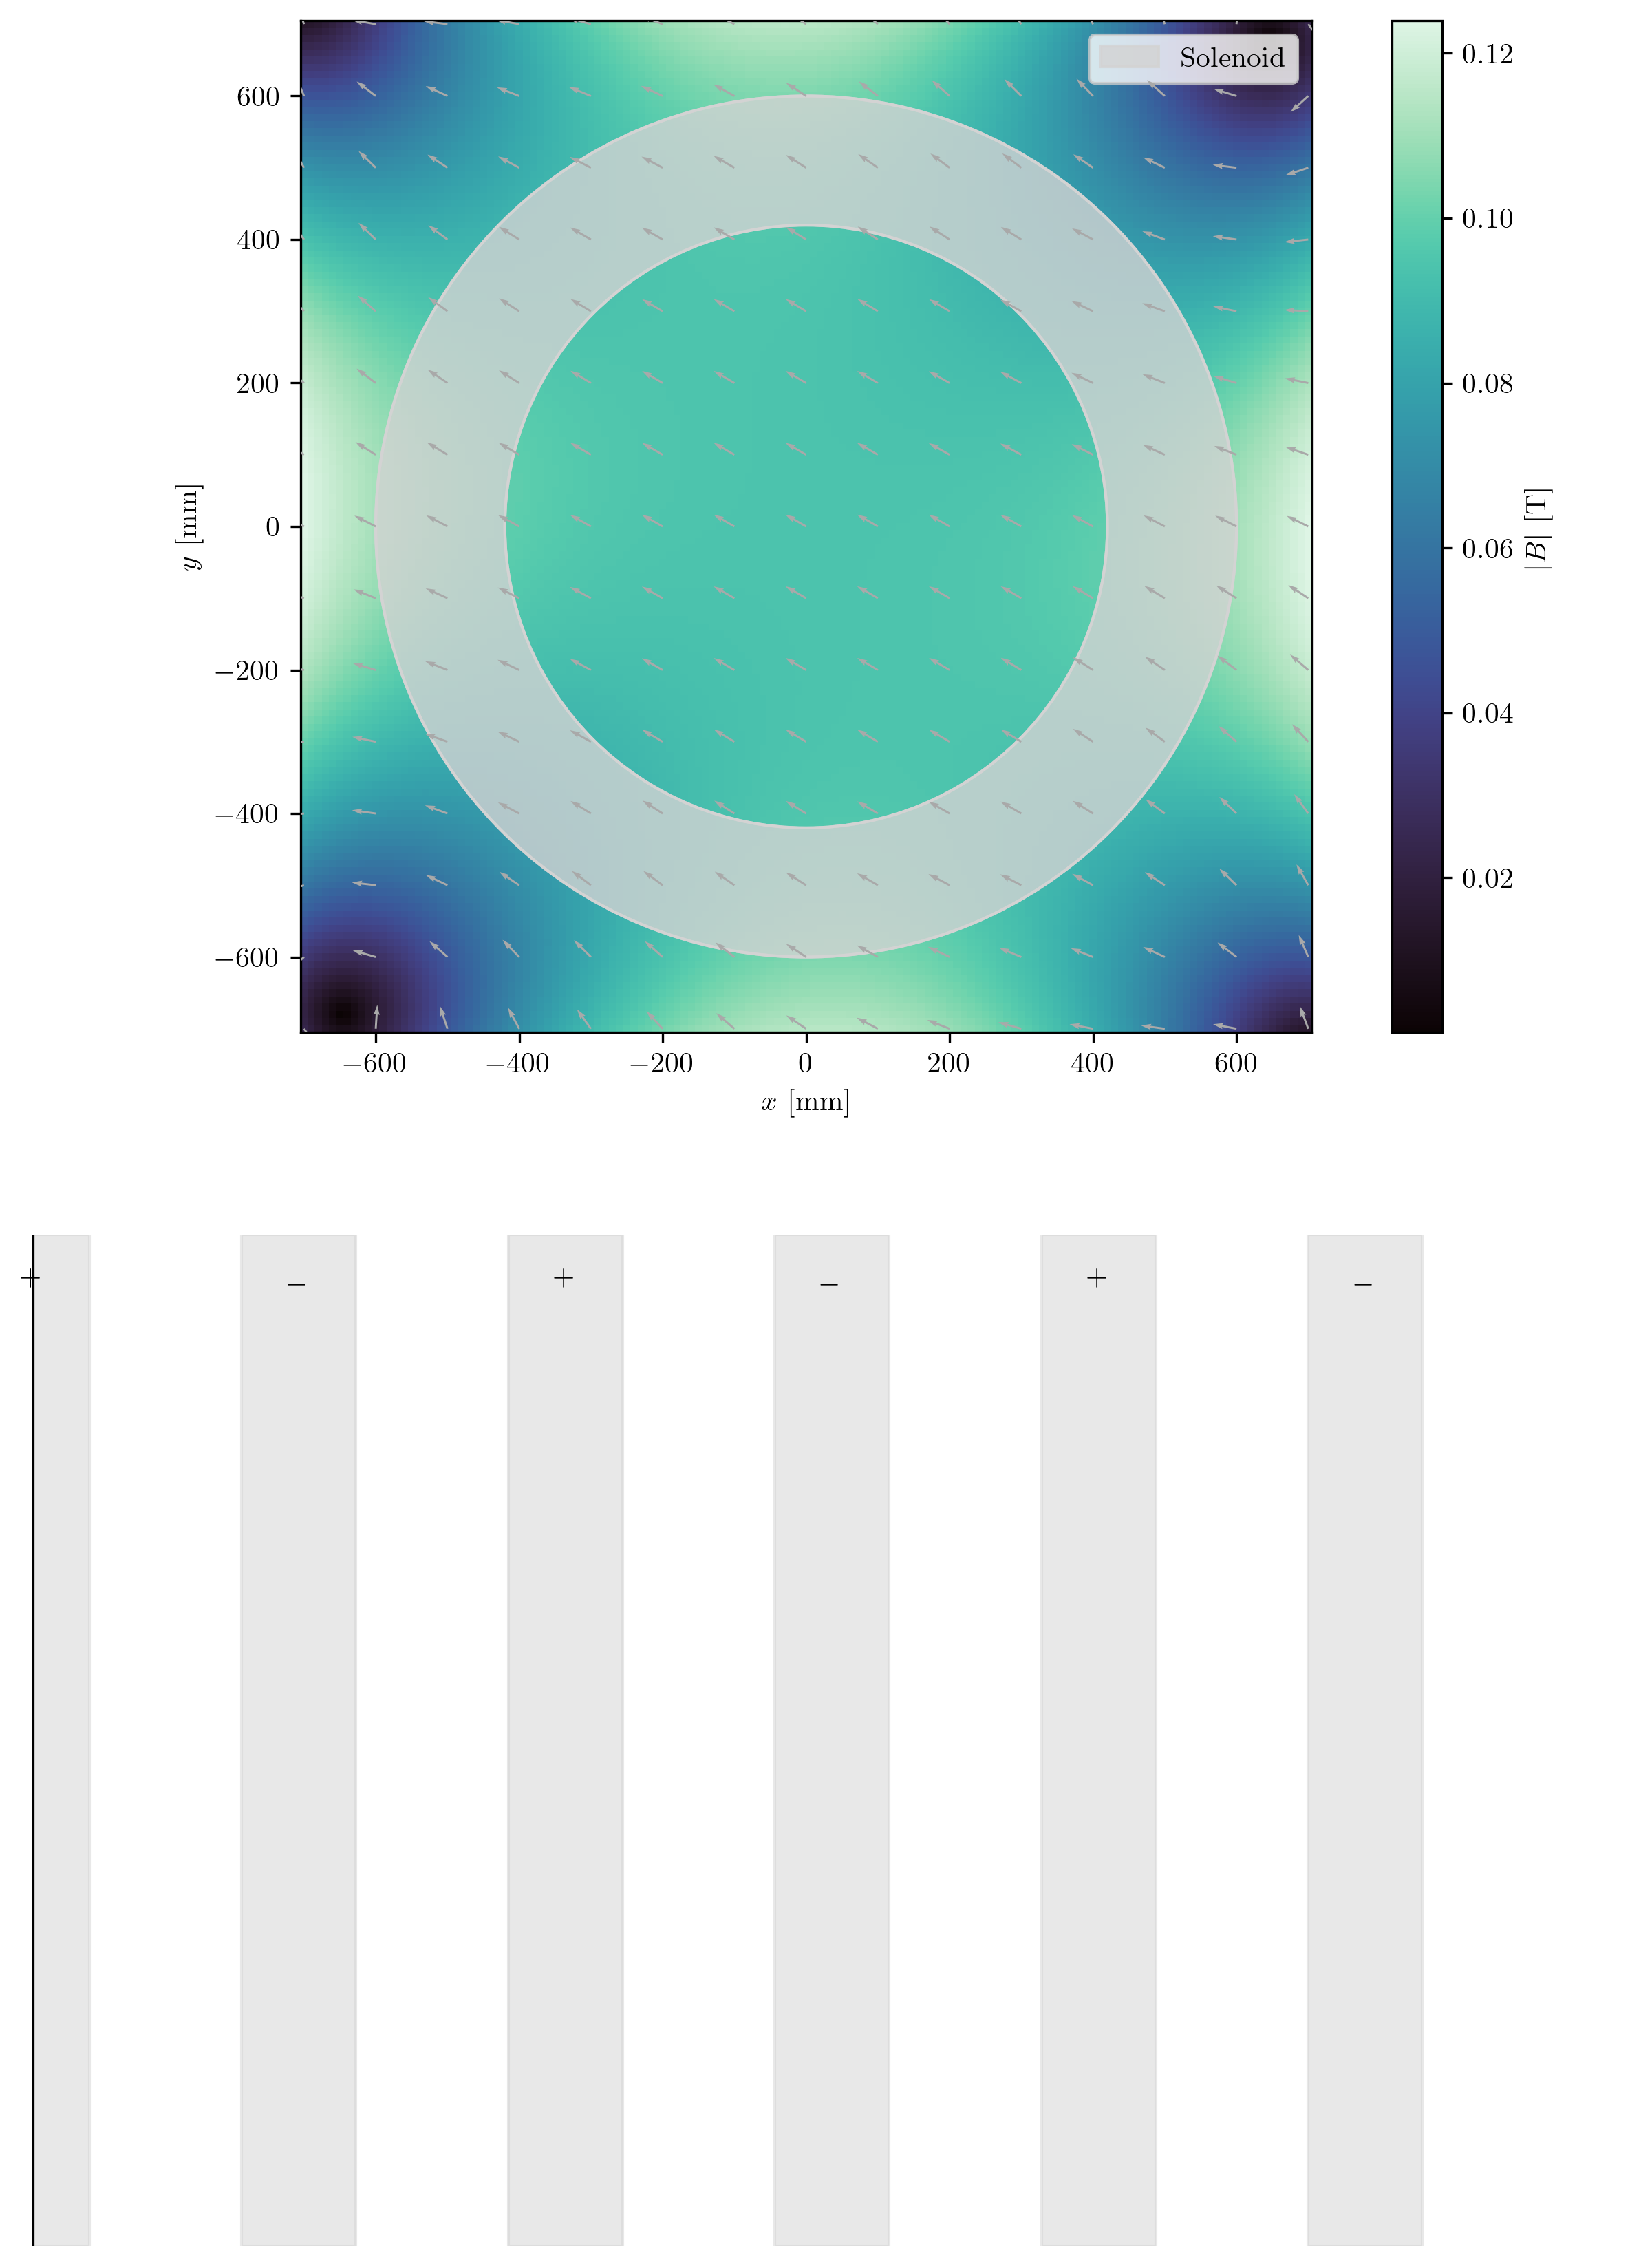

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(10,14))
ax, ax2 = axs[0], axs[1]

arrayy = [0, 0]
ax2.set_xlim(0, 4200)
plotLattice(ax2, label=True)
ax2.set_yticks([])
ax2.set_xticks([])
ax2.set_frame_on(False)
vline = ax2.axvline(x=df['z'].values[0], color='black')

cmap = sns.color_palette('mako', as_cmap=True)
pcm = ax.pcolormesh(X, Y, B_by_z[0], cmap=cmap)
plt.colorbar(pcm, ax=ax, label='$|B|$ [T]') # may require some scaling?

ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
plotSolenoid(ax, color='lightgray')
ax.set_aspect('equal')

quiver_plot = None

step = 10

def animate(frame):
    global quiver_plot

    z_val = df['z'].values[frame]
    vline.set_xdata([z_val])

    Bx_grid = Bx_by_z[frame]
    By_grid = By_by_z[frame]
    B_grid = B_by_z[frame]

    X_ds = X[::step, ::step]
    Y_ds = Y[::step, ::step]
    Bx_ds = Bx_grid[::step, ::step]
    By_ds = By_grid[::step, ::step]
    B_ds = B_grid[::step, ::step]

    Bx_norm = Bx_ds / (B_ds + 1e-12)
    By_norm = By_ds / (B_ds + 1e-12)

    pcm.set_array(B_grid.ravel())

    if quiver_plot:
        quiver_plot.remove()

    quiver_plot = ax.quiver(
        X_ds, Y_ds, Bx_norm, By_norm,
        color='darkgray',
        angles="xy", scale_units="xy", scale=0.03,
        width=0.002, zorder=10
    )

    return [vline, quiver_plot]

animation = FuncAnimation(fig, animate, frames=len(df['z'].values), interval=100, blit=False, repeat=False)
animation.save(ani_dir+'multipole_expansion_quiver.gif', writer='pillow')

## Isolate contributions from solenoid rotations

In [14]:
data_norot = readFieldMapData(file_norot)

data_diff = data.copy()
data_diff['Bx'] = data['Bx'] - data_norot['Bx']
data_diff['By'] = data['By'] - data_norot['By']
data_diff['Bz'] = data['Bz'] - data_norot['Bz']
data_diff['Br'] = data['Br'] - data_norot['Br']

In [15]:
df_diff, df_diff2 = func(data_diff, X, Y)

#### Magnitudes:

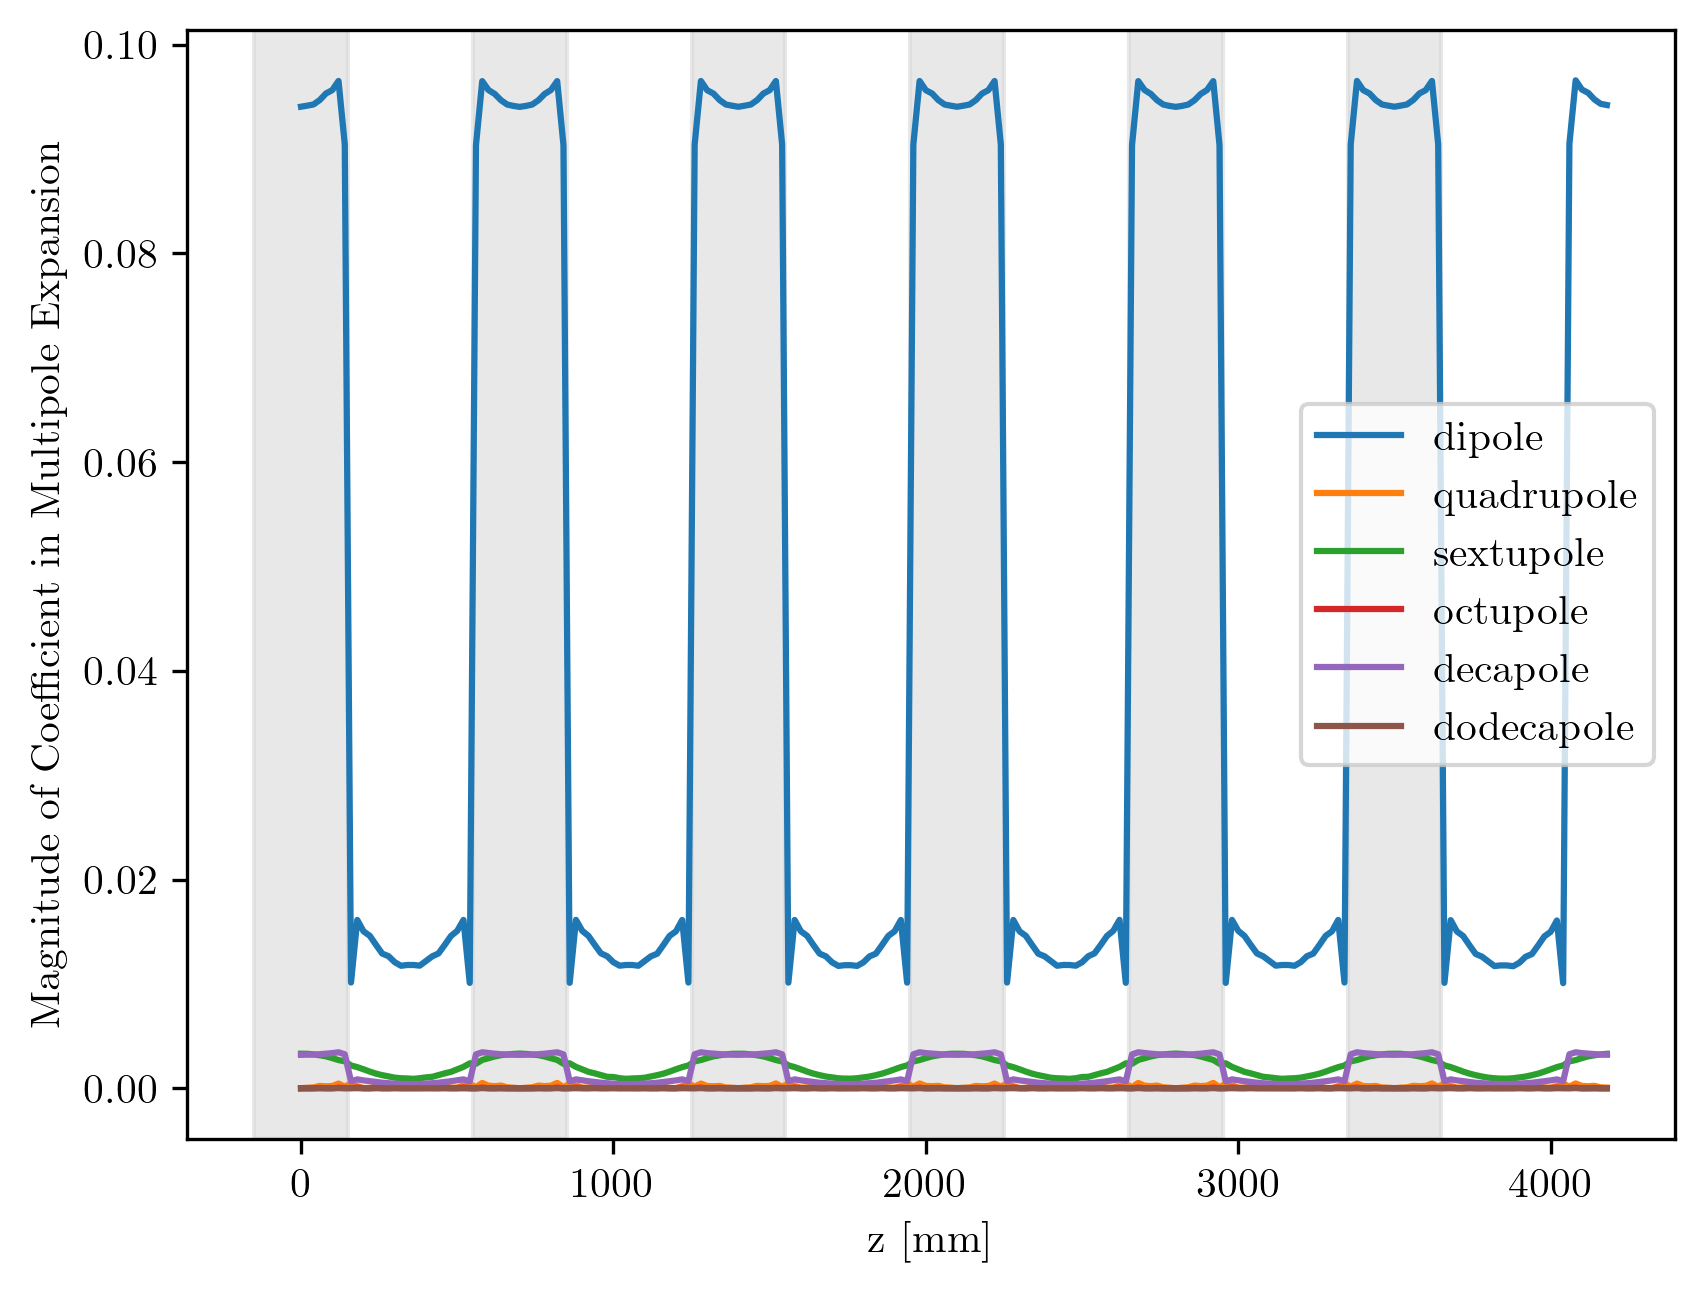

In [16]:
fig, ax = plt.subplots()
plt.plot(df_diff['z'], df_diff['n=1'], label='dipole')
plt.plot(df_diff['z'], df_diff['n=2'], label='quadrupole')
plt.plot(df_diff['z'], df_diff['n=3'], label='sextupole')
plt.plot(df_diff['z'], df_diff['n=4'], label='octupole')
plt.plot(df_diff['z'], df_diff['n=5'], label='decapole')
plt.plot(df_diff['z'], df_diff['n=6'], label='dodecapole')
plt.legend()
plt.xlabel('z [mm]')
plt.ylabel('Magnitude of Coefficient in Multipole Expansion')
plotLattice(ax)
plt.show()

#### Phases:

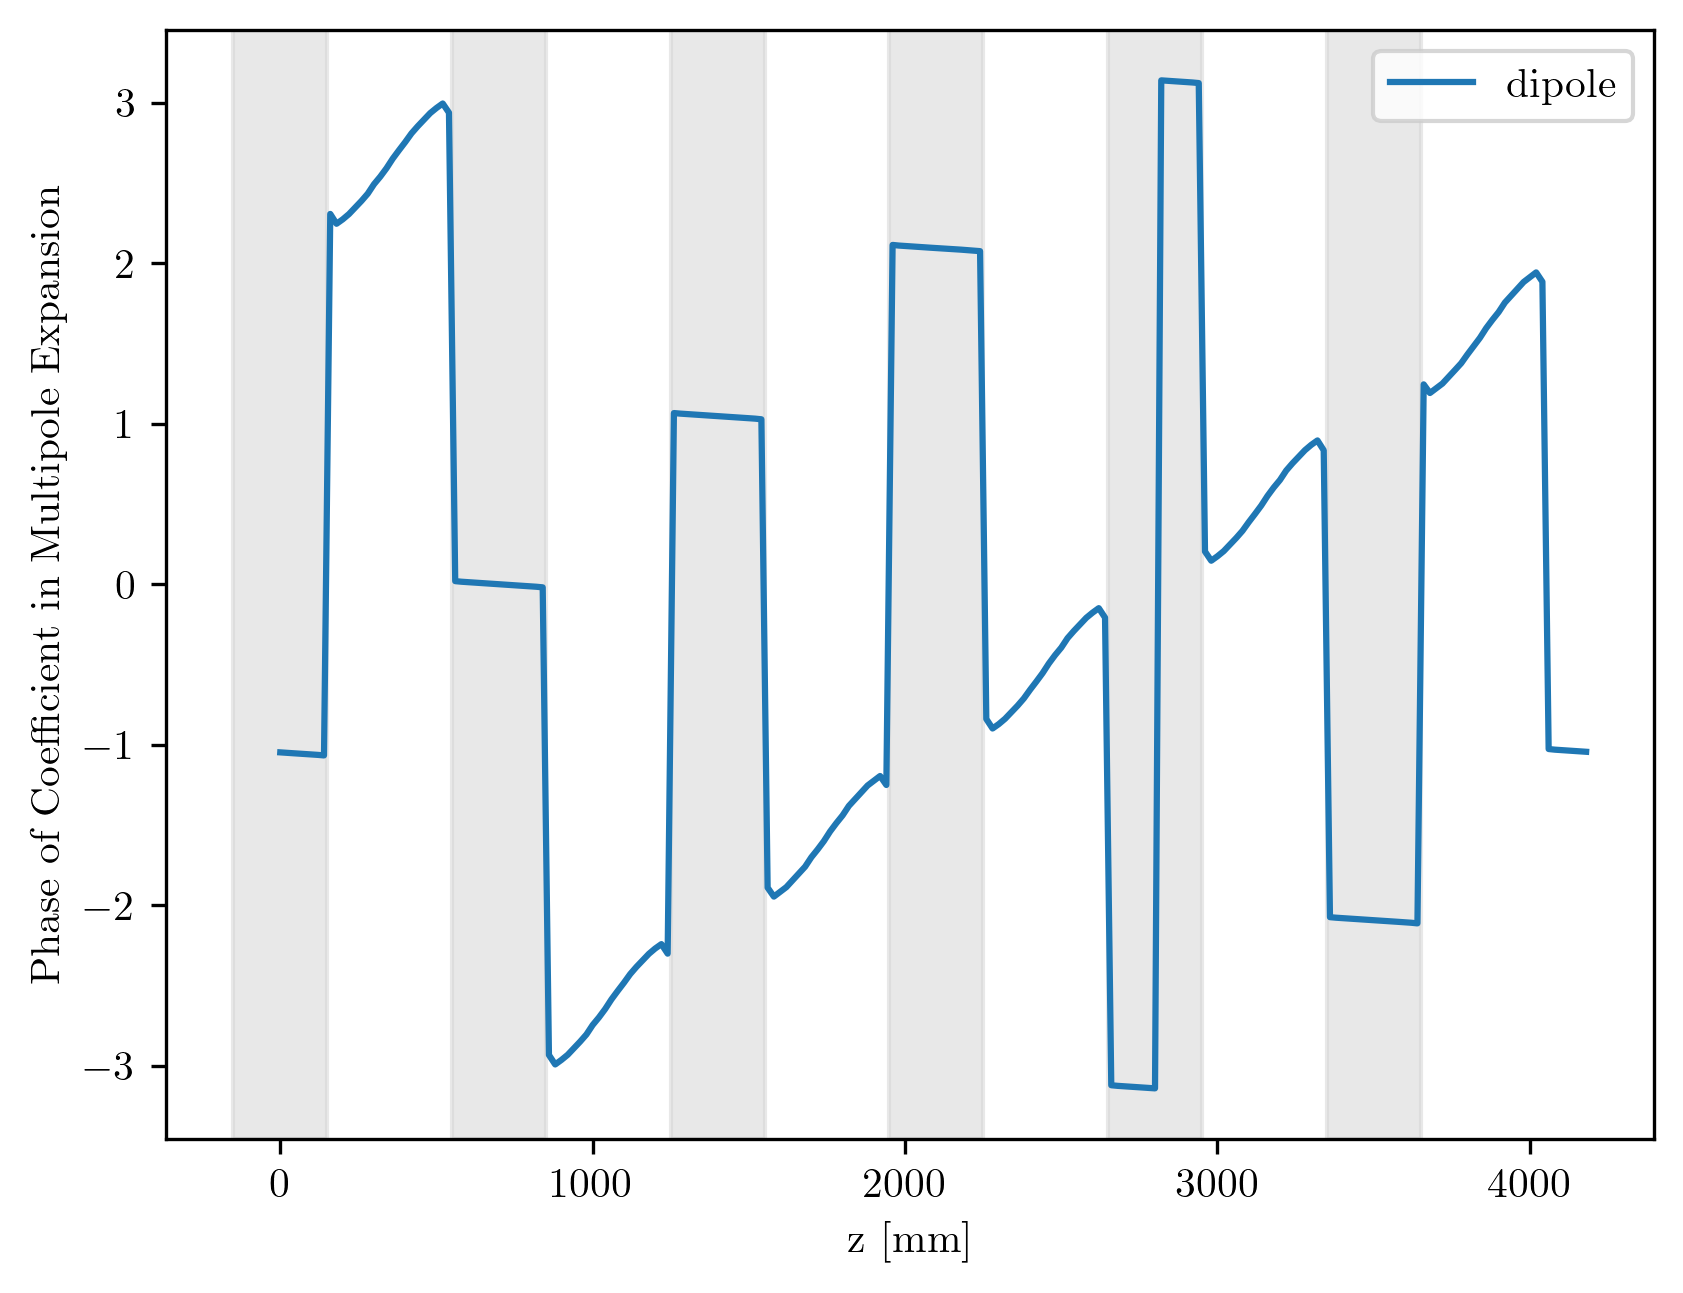

In [17]:
fig, ax = plt.subplots()
plt.plot(df_diff2['z'], df_diff2['n=1'], label='dipole', color='tab:blue')
plt.legend()
plt.xlabel('z [mm]')
plt.ylabel('Phase of Coefficient in Multipole Expansion')
plotLattice(ax)
plt.show()

In [18]:
Bx_by_z = []
By_by_z = []
B_by_z = []
for z in df_diff['z'].values:

        coeff_list_mag = df_diff.loc[np.where(df_diff['z']==z)[0]].values[0][1:]
        coeff_list_phase = df_diff2.loc[np.where(df_diff2['z']==z)[0]].values[0][1:]

        Bx_slice, By_slice = computeField(x, y, coeff_list_mag, coeff_list_phase)
        Bx_by_z.append(Bx_slice)
        By_by_z.append(By_slice)
        theta = np.arctan2(By_slice, Bx_slice)
        B = Bx_slice*np.cos(theta) + By_slice*np.sin(theta)
        B_by_z.append(B)

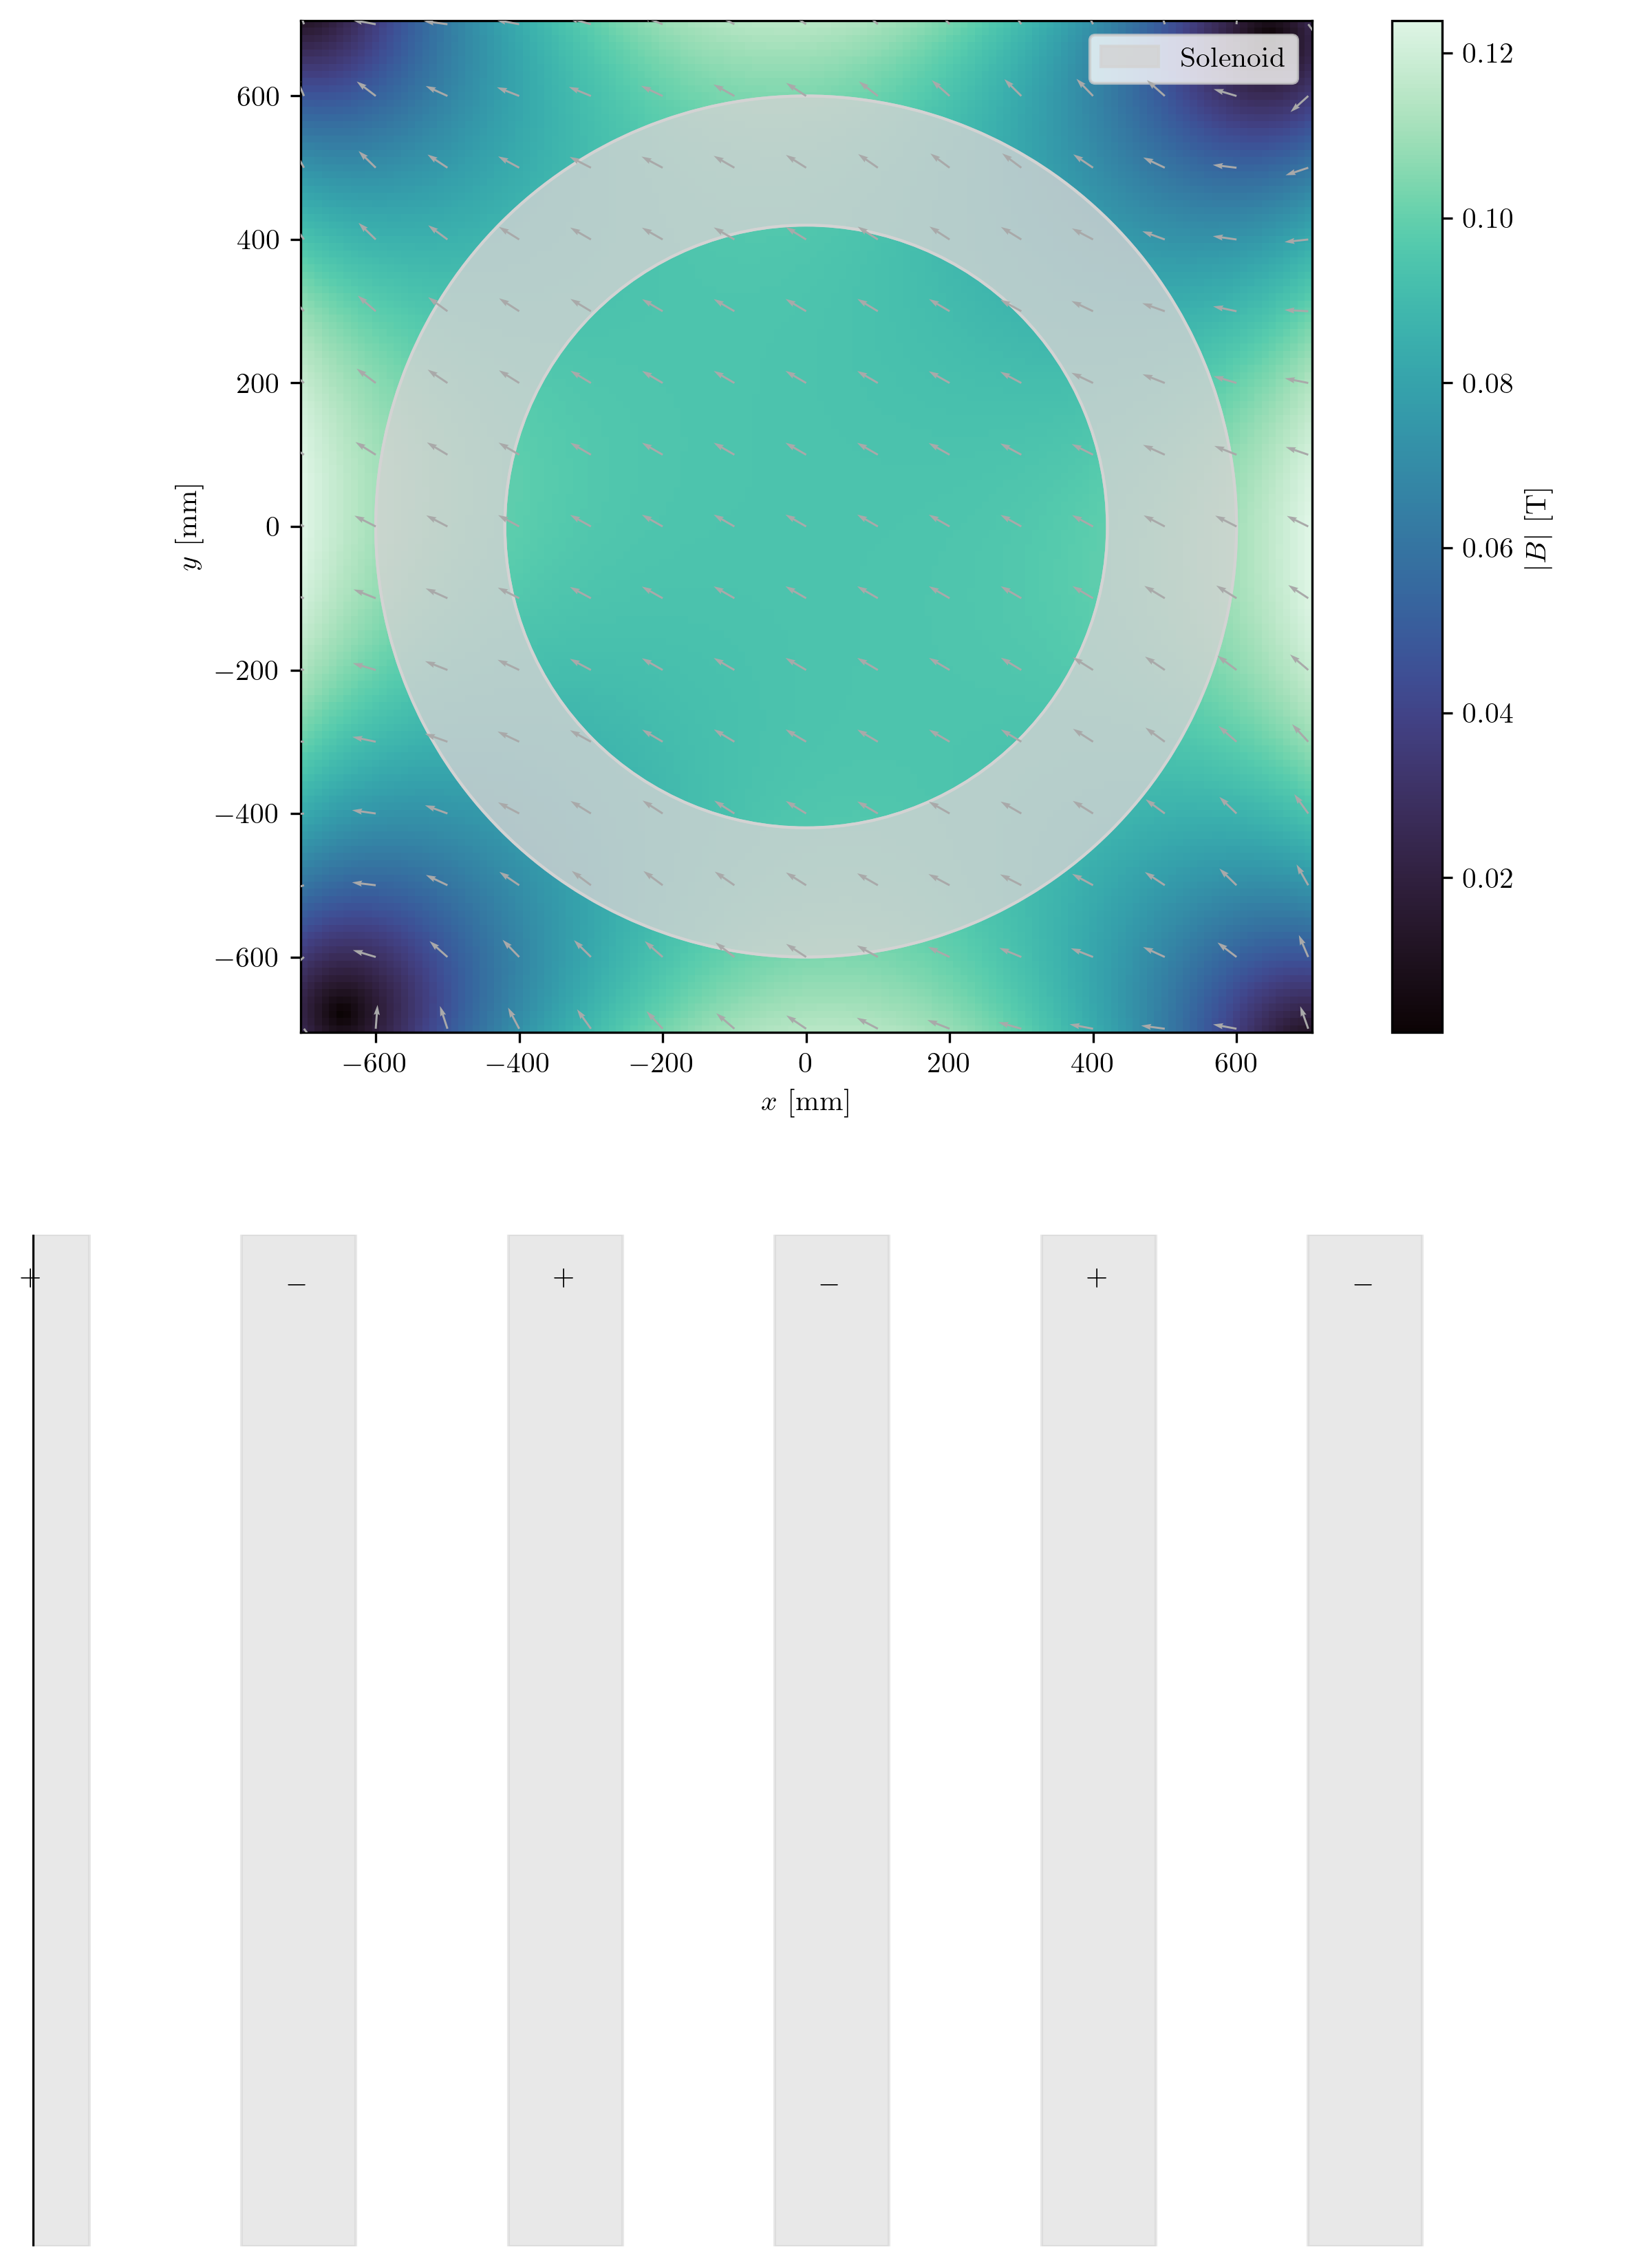

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(10,14))
ax, ax2 = axs[0], axs[1]

arrayy = [0, 0]
ax2.set_xlim(0, 4200)
plotLattice(ax2, label=True)
ax2.set_yticks([])
ax2.set_xticks([])
ax2.set_frame_on(False)
vline = ax2.axvline(x=df['z'].values[0], color='black')

cmap = sns.color_palette('mako', as_cmap=True)
pcm = ax.pcolormesh(X, Y, B_by_z[0], cmap=cmap)
plt.colorbar(pcm, ax=ax, label='$|B|$ [T]') # may require some scaling?

ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
plotSolenoid(ax, color='lightgray')
ax.set_aspect('equal')

quiver_plot = None

step = 10

def animate(frame):
    global quiver_plot

    z_val = df['z'].values[frame]
    vline.set_xdata([z_val])

    Bx_grid = Bx_by_z[frame]
    By_grid = By_by_z[frame]
    B_grid = B_by_z[frame]

    X_ds = X[::step, ::step]
    Y_ds = Y[::step, ::step]
    Bx_ds = Bx_grid[::step, ::step]
    By_ds = By_grid[::step, ::step]
    B_ds = B_grid[::step, ::step]

    Bx_norm = Bx_ds / (B_ds + 1e-12)
    By_norm = By_ds / (B_ds + 1e-12)

    pcm.set_array(B_grid.ravel())

    if quiver_plot:
        quiver_plot.remove()

    quiver_plot = ax.quiver(
        X_ds, Y_ds, Bx_norm, By_norm,
        color='darkgray',
        angles="xy", scale_units="xy", scale=0.03,
        width=0.002, zorder=10
    )

    return [vline, quiver_plot]

animation = FuncAnimation(fig, animate, frames=len(df['z'].values), interval=100, blit=False, repeat=False)
animation.save(ani_dir+'multipole_expansion_quiver_diff.gif', writer='pillow')

#### Limit to region within the solenoid

In [20]:
data_diff['r'] = np.sqrt(data_diff['x']**2 + data_diff['y']**2)

lim = 400
data_diff_lim = data_diff[data_diff['r'] < lim]

In [21]:
x = np.unique(data_diff_lim['x'].values)
y = np.unique(data_diff_lim['y'].values)
X, Y = np.meshgrid(x, y)
Xlim, Ylim = X.copy(), Y.copy()

mask = X**2 + Y**2 < lim**2

for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        if mask[i][j] == False:
            Xlim[i][j] = np.nan
            Ylim[i][j] = np.nan

# Fit over circular region only
df_diff_lim, df_diff_lim2 = func(data_diff_lim, Xlim, Ylim, R_ref=lim)

#### Magnitudes:

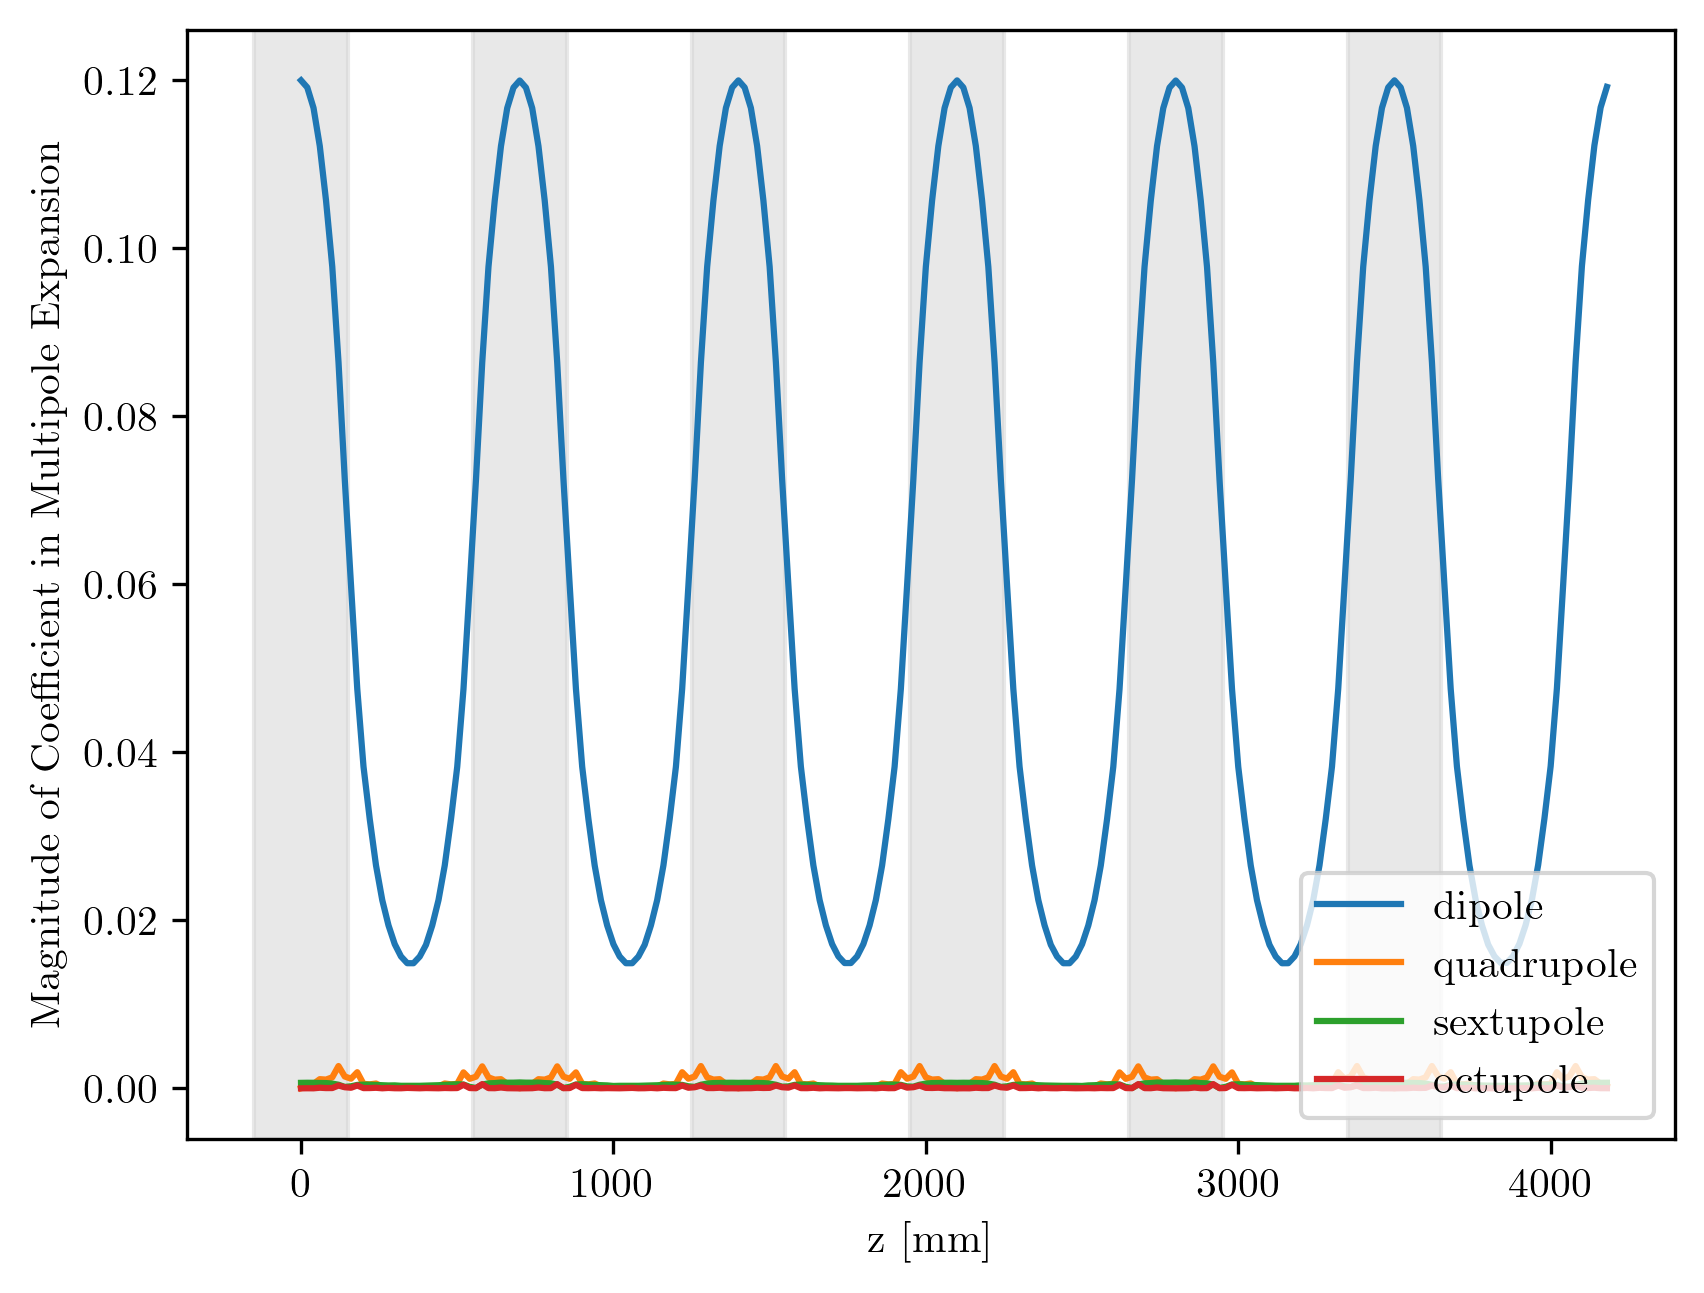

In [22]:
fig, ax = plt.subplots()
plt.plot(df_diff_lim['z'], df_diff_lim['n=1'], label='dipole')
plt.plot(df_diff_lim['z'], df_diff_lim['n=2'], label='quadrupole')
plt.plot(df_diff_lim['z'], df_diff_lim['n=3'], label='sextupole')
plt.plot(df_diff_lim['z'], df_diff_lim['n=4'], label='octupole')
plt.legend(loc='lower right')
plt.xlabel('z [mm]')
plt.ylabel('Magnitude of Coefficient in Multipole Expansion')
plotLattice(ax)
plt.show()

#### Phases:

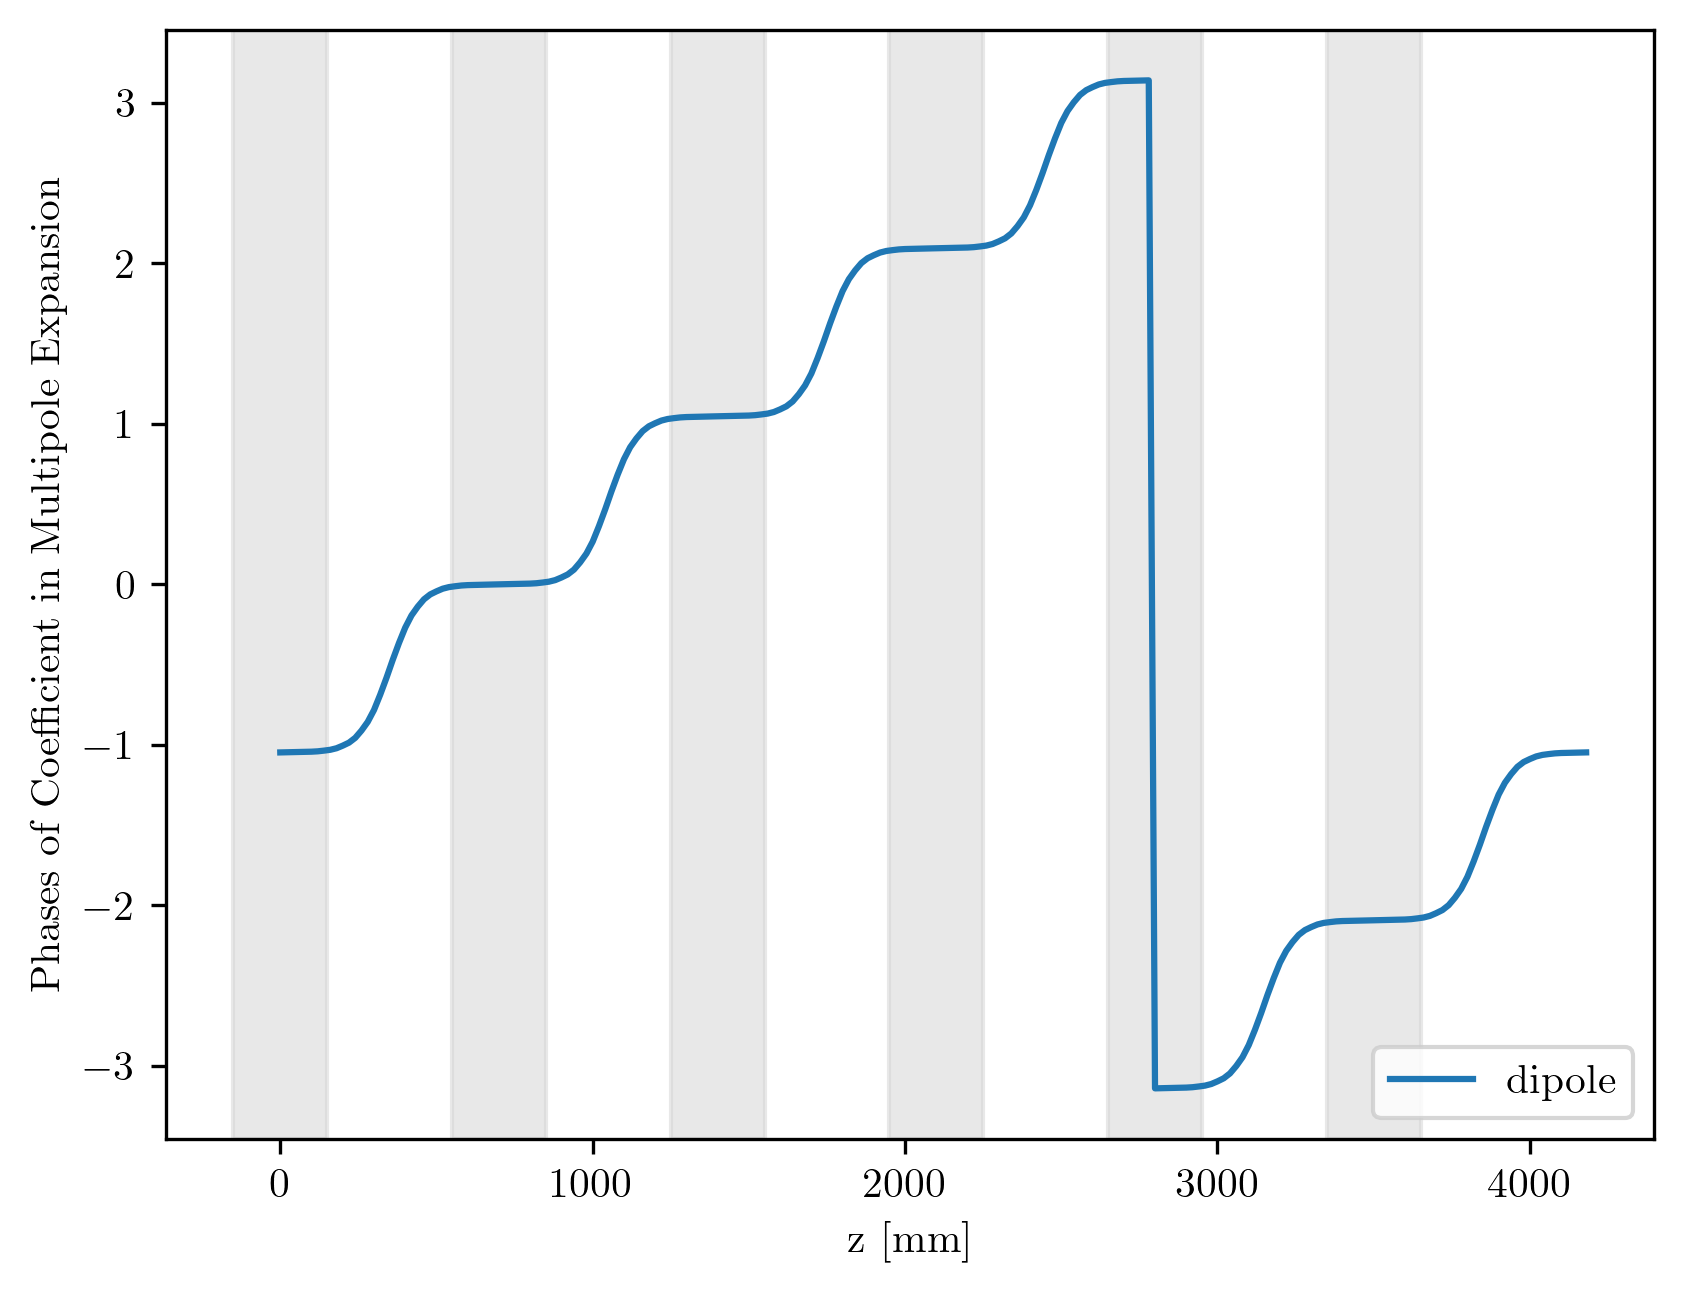

In [27]:
fig, ax = plt.subplots()
plt.plot(df_diff_lim2['z'], df_diff_lim2['n=1'], label='dipole')
plt.legend(loc='lower right')
plt.xlabel('z [mm]')
plt.ylabel('Phases of Coefficient in Multipole Expansion')
plotLattice(ax)
plt.show()

In [23]:
Bx_by_z = []
By_by_z = []
B_by_z = []
for z in df_diff_lim['z'].values:

        coeff_list_mag = df_diff_lim.loc[np.where(df_diff_lim['z']==z)[0]].values[0][1:]
        coeff_list_phase = df_diff_lim2.loc[np.where(df_diff_lim2['z']==z)[0]].values[0][1:]

        Bx_slice, By_slice = computeField(x, y, coeff_list_mag, coeff_list_phase)
        Bx_by_z.append(Bx_slice)
        By_by_z.append(By_slice)
        theta = np.arctan2(By_slice, Bx_slice)
        B = Bx_slice*np.cos(theta) + By_slice*np.sin(theta)
        B_by_z.append(B)

In [24]:
# Map back to circular region after evaluating (to match region in which fit was performed)
for z in range(len(B_by_z)):
    for i in range(B_by_z[i].shape[0]):
        for j in range(B_by_z[i].shape[1]):
            if mask[i][j] == False:
                B_by_z[z][i][j] = np.nan

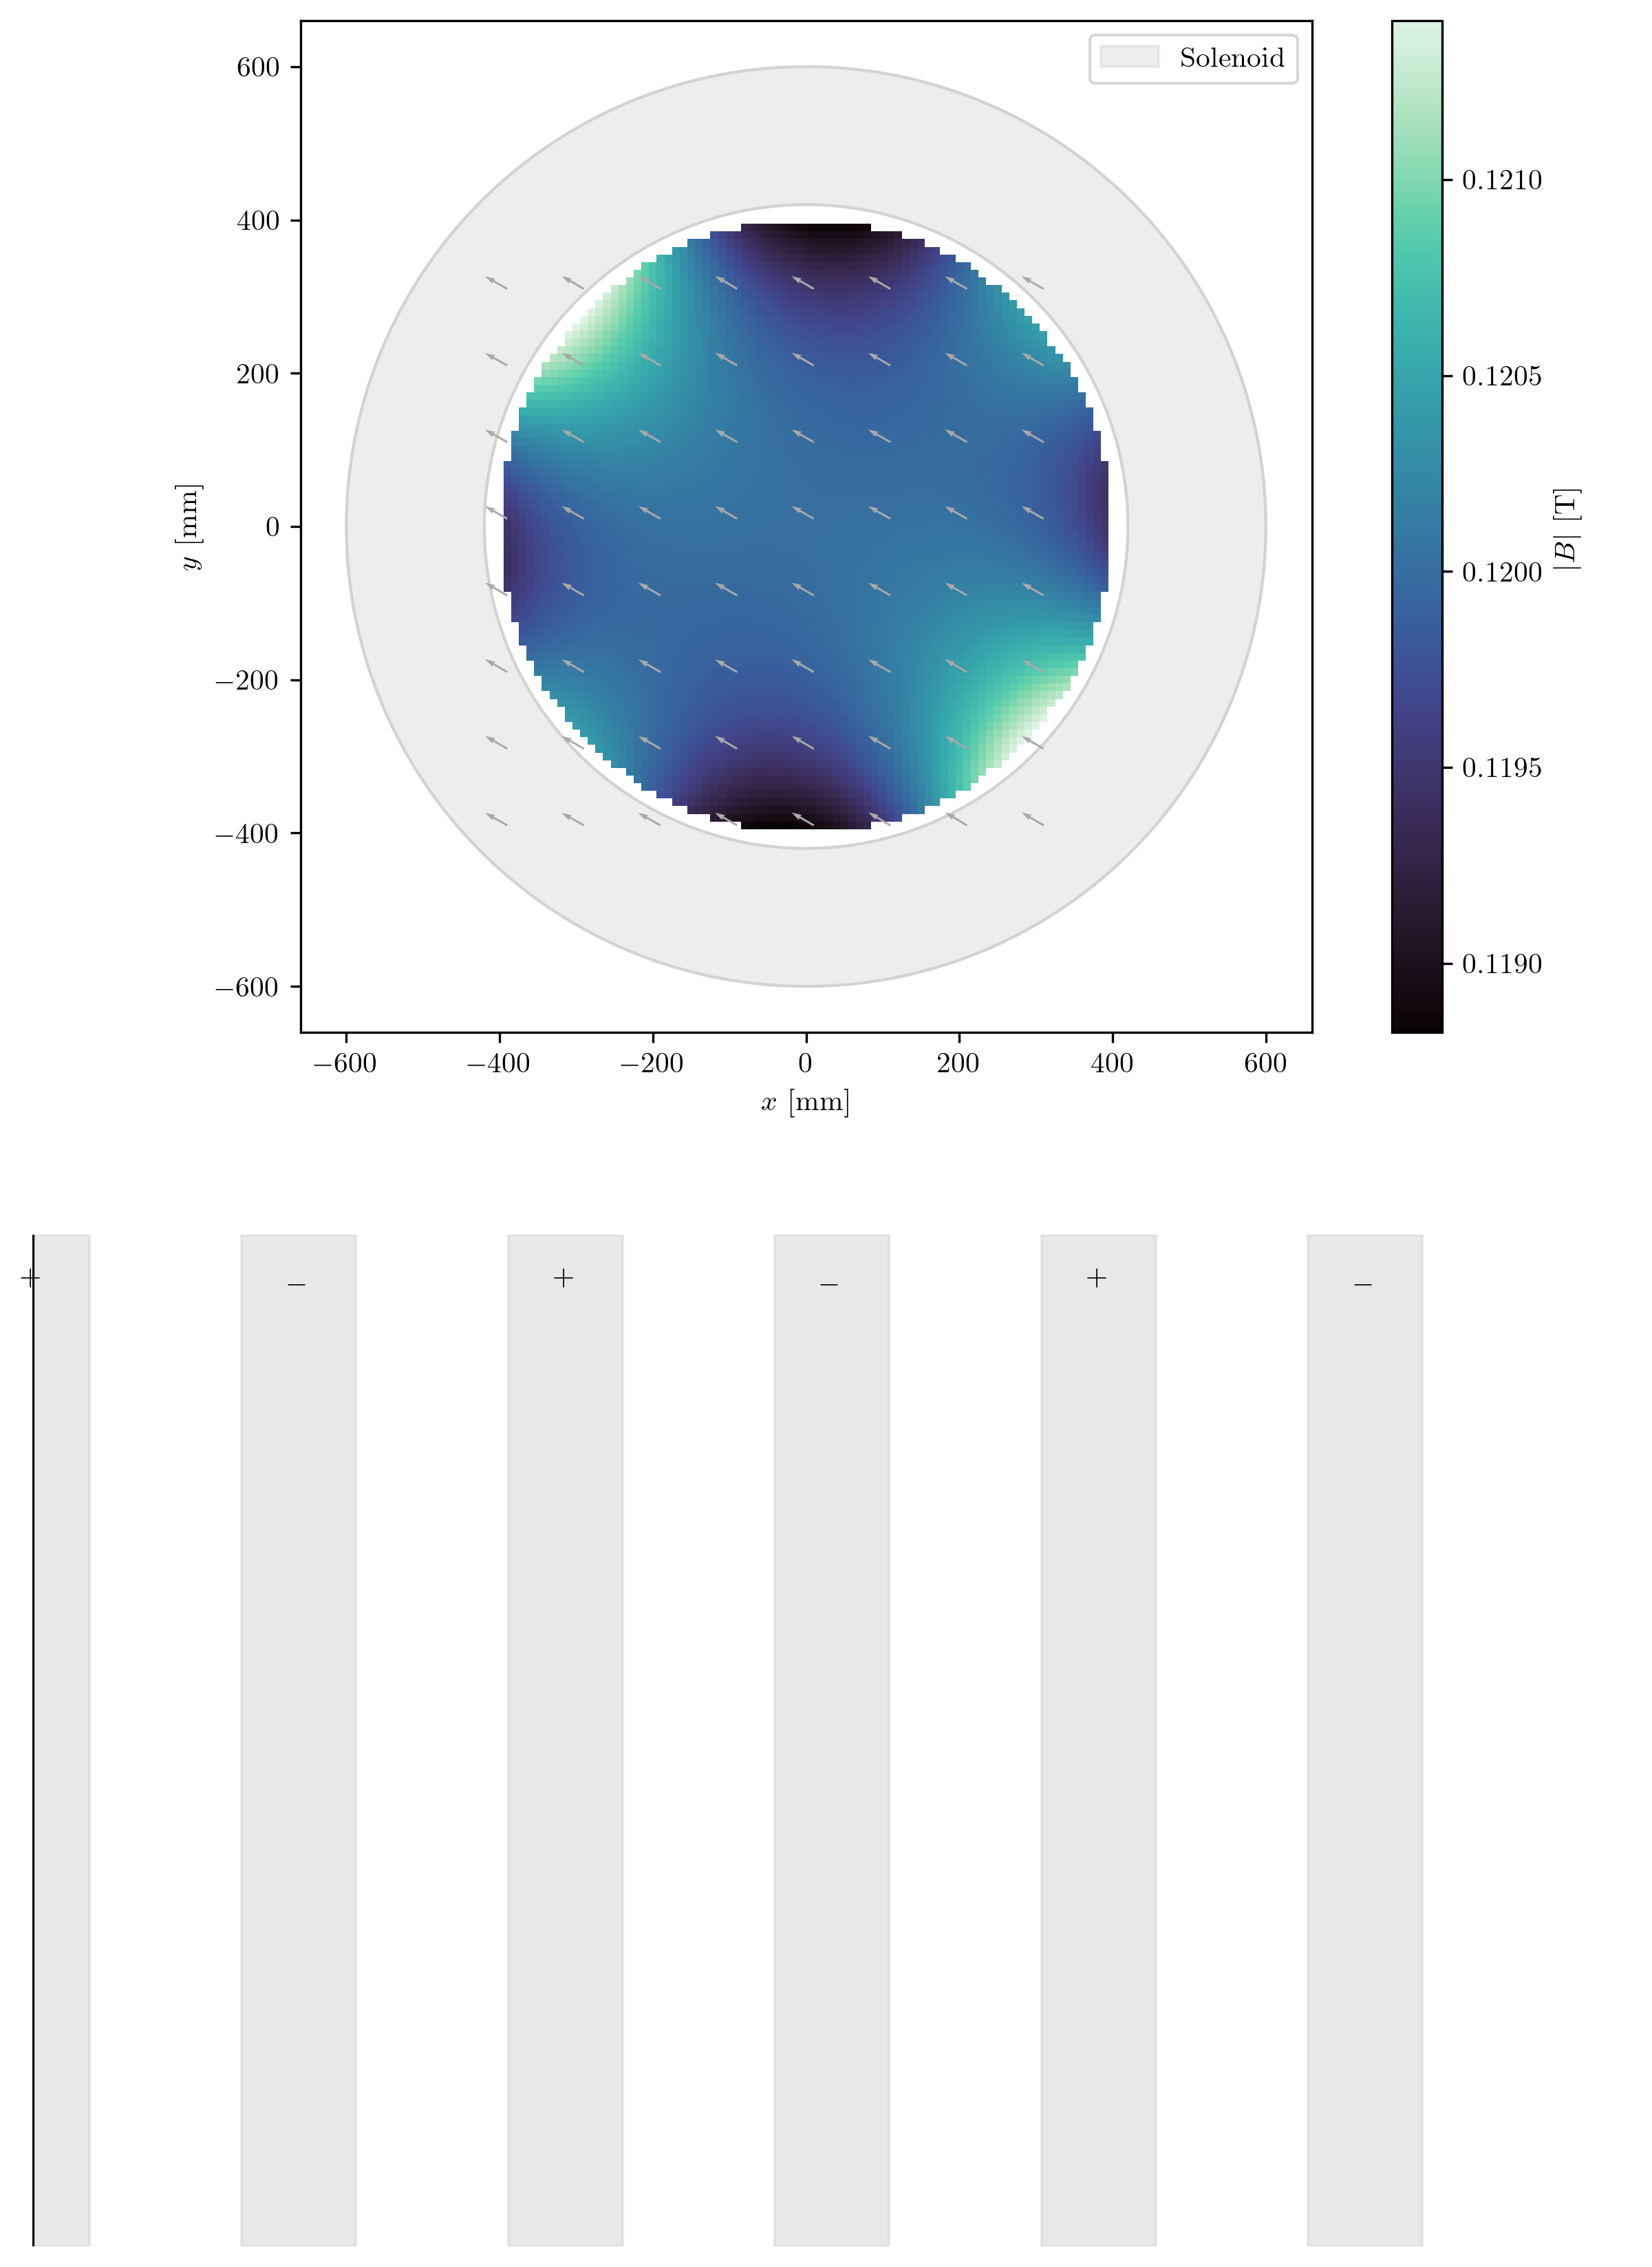

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(10,14))
ax, ax2 = axs[0], axs[1]

arrayy = [0, 0]
ax2.set_xlim(0, 4200)
plotLattice(ax2, label=True)
ax2.set_yticks([])
ax2.set_xticks([])
ax2.set_frame_on(False)
vline = ax2.axvline(x=df['z'].values[0], color='black')

cmap = sns.color_palette('mako', as_cmap=True)
pcm = ax.pcolormesh(X, Y, B_by_z[0], cmap=cmap)
plt.colorbar(pcm, ax=ax, label='$|B|$ [T]') # may require some scaling?

ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
circle_inner = plt.Circle([0,0], radius=a, fill=False, linestyle='-', color='lightgray')
ax.add_patch(circle_inner)
circle_outer = plt.Circle([0,0], radius=b, fill=False, linestyle='-', color='lightgray')
ax.add_patch(circle_outer)
fill = Wedge(center=(0, 0), r=b, theta1=0, theta2=360, width=b - a, color='lightgray', label='Solenoid', alpha=0.4)
ax.add_patch(fill)
ax.set_aspect('equal')
ax.legend(loc='upper right')

quiver_plot = None

step = 10

def animate(frame):
    global quiver_plot

    z_val = df['z'].values[frame]
    vline.set_xdata([z_val])

    Bx_grid = Bx_by_z[frame]
    By_grid = By_by_z[frame]
    B_grid = B_by_z[frame]

    X_ds = X[::step, ::step]
    Y_ds = Y[::step, ::step]
    Bx_ds = Bx_grid[::step, ::step]
    By_ds = By_grid[::step, ::step]

    magnitude = np.sqrt(Bx_ds**2 + By_ds**2)
    Bx_norm = Bx_ds / (magnitude + 1e-12)
    By_norm = By_ds / (magnitude + 1e-12)

    pcm.set_array(B_grid.ravel())

    if quiver_plot:
        quiver_plot.remove()

    quiver_plot = ax.quiver(
        X_ds, Y_ds, Bx_norm, By_norm,
        color='darkgray',
        angles="xy", scale_units="xy", scale=0.03,
        width=0.002, zorder=10
    )

    return [vline, quiver_plot]

animation = FuncAnimation(fig, animate, frames=len(df['z'].values), interval=100, blit=False, repeat=False)
animation.save(ani_dir+'multipole_expansion_quiver_diff_lim.gif', writer='pillow')